<a href="https://colab.research.google.com/github/VishakBharadwaj94/Image_Similarity_AutoEncoder/blob/main/Image_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
! unzip -q /content/drive/MyDrive/dataset.zip -d /content

replace /content/dataset/3604.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [59]:
import torch
from PIL import Image
import os
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


In [60]:
from pathlib import Path

path = Path('/content')
data = path/'dataset'

In [61]:
class Dataset:
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.data_path))

    def __getitem__(self, idx):
        img_loc = self.data_path/f'{idx}.jpg'
        image = Image.open(img_loc).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image,image

In [62]:
dataset = Dataset(data)

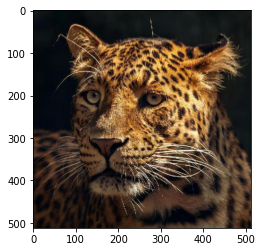

In [63]:
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

def see_data(idx):
  img1,_ = dataset[idx]
  imshow(img1)

see_data(7)

In [64]:
[train_size,val_size] =(len(dataset)-738),738
train_size,val_size

(4001, 738)

In [65]:
class toTensor:

  def __call__(self,image):
    image = np.array(image)
    image = image.transpose((2, 0, 1))
    return (torch.from_numpy(image)).float()

In [66]:
tfms = T.Compose(
    [
     T.Resize((512,512)),
     T.RandomHorizontalFlip(),
     toTensor(),
    ]
) 

In [67]:
dataset = Dataset(data,tfms)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
 
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

In [68]:
xb,yb = next(iter(train_loader))

In [69]:
xb.shape

torch.Size([32, 3, 512, 512])

In [70]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d((2, 2))

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        return x

class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.deconv2 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()

        self.deconv3 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU()

    def forward(self, x):

        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        return x

In [71]:
enc = ConvEncoder()
out1= enc(dataset[0][0].unsqueeze(0).float())
out1.shape

torch.Size([1, 64, 64, 64])

In [72]:
dec = ConvDecoder()
out2= dec(out1)
out2.shape

torch.Size([1, 3, 512, 512])

In [73]:
enc_models = path/'model/encoder'
dec_models = path/'model/decoder'
enc_models,dec_models

(PosixPath('/content/model/encoder'), PosixPath('/content/model/decoder'))

In [74]:
criterion = nn.MSELoss()
autoencoder_params = list(enc.parameters()) + list(dec.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-7)

In [75]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer,max_lr,epochs):

    encoder.train()
    decoder.train()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    losses = 0 
    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.cuda()
        target_img = target_img.cuda()

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
        loss.backward()
        losses+=loss.item()
        optimizer.step()
        sched.step()
    return losses/len(train_loader)


def val_step(encoder, decoder, val_loader, loss_fn):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        losses = 0 
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.cuda()
            target_img = target_img.cuda()

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)
            loss = loss_fn(dec_output, target_img)
            losses+=loss.item()
          

    return losses/len(val_loader)

In [76]:
enc.cuda()
dec.cuda()

epochs = 1

for i in optimizer.param_groups:
      max_lr = i['lr']

for epoch in tqdm(range(epochs)):

    train_loss = train_step(enc, dec, train_loader, criterion, optimizer,max_lr,epochs)
    val_loss = val_step(enc, dec, val_loader, criterion)
    print(f"Epochs = {epoch}, Training Loss : {train_loss} ,Validation Loss : {val_loss}")

    torch.save(enc.state_dict(), enc_models/f'{epoch}.pt')
    torch.save(dec.state_dict(), dec_models/f'{epoch}.pt')





  0%|          | 0/1 [00:00<?, ?it/s]

FileNotFoundError: ignored